# Objective

*buatlah model prediksi, untuk mengetahui top 5 SKU parts mana yang dalam waktu 6 bulan kedepan di butuhkan region / wilayah se nasional.*

# 1. Preparation

## 1.1 Importing Libraries

In [1]:
# !pip install pystan

In [2]:
# conda install -c conda-forge fbprophet

In [3]:
# !pip install pystan fbprophet

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import fbprophet

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
sns.set_palette("Paired")

# from fbprophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
# sns.set_style("whitegrid", {'axes.grid' : False})

# plt.style.use('tableau-colorblind10')
# plt.style.available

## 1.2 Load Datasets

In [5]:
df = pd.read_csv('Automotive_Inventory_v2.csv')
df

,Order Date,State,Dealer,Product Name,Quantity,SKU
0,2015-01-02,Wisconsin,C,Fog Lamp,1,SV-20365
1,2015-01-03,Illinois,C,Headlight,1,MA-17560
2,2015-01-03,Illinois,C,Tail Lamp,1,EP-13915
3,2015-01-03,New York,B,Fender,1,JL-15835
4,2015-01-03,Texas,C,Fender,1,JL-15835
...,...,...,...,...,...,...
8420,2018-12-30,Colorado,A,Fender,1,JL-15835
8421,2018-12-30,Indiana,C,Filter,1,AP-10915
8422,2018-12-30,New York,B,Fender,1,JL-15835
8423,2018-12-30,New York,B,Front Bumper,1,WB-21850


## 1.3 Dataset Information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order Date    8425 non-null   object
 1   State         8425 non-null   object
 2   Dealer        8425 non-null   object
 3   Product Name  8425 non-null   object
 4   Quantity      8425 non-null   int64 
 5   SKU           8425 non-null   object
dtypes: int64(1), object(5)
memory usage: 395.0+ KB


In [7]:
disc_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'int64']
cont_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'float']
cat_feat_df = [feature for feature in df.columns if df[feature].dtypes == 'O']

In [8]:
print(f'Shape Data: {df.shape[0]} rows & {df.shape[1]} features')
print(f'Number of discrete features = {len(disc_feat_df)}')
print(f'Number of continous features = {len(cont_feat_df)}')
print(f'Number of categorical features = {len(cat_feat_df)}')

Shape Data: 8425 rows & 6 features
Number of discrete features = 1
Number of continous features = 0
Number of categorical features = 5


In [9]:
df.select_dtypes(object).describe().T

,count,unique,top,freq
Order Date,8425,1230,2017-05-09,31
State,8425,25,California,1651
Dealer,8425,4,A,2631
Product Name,8425,10,Front Bumper,1442
SKU,8425,10,WB-21850,1442


Bisa dilihat bahwa pada:
- Tanggal **9 Mei 2017** terjadi penjualan order terbanyak sebesar **31 spare parts**
- Negara bagian **California** dengan penjualan sebanyak **1651**
- dan **Front Bumper** merupakan spare part yang paling banyak di cari oleh customer

## 1.4 Null Values

In [10]:
df_null = pd.DataFrame(data = [df.isna().sum(), round(df.isna().sum()/df.shape[0]*100, 2)], 
                       index=['Count', 'Percentage']).T.style.background_gradient(cmap='Blues')
df_null

,Count,Percentage
Order Date,0.000000,0.000000
State,0.000000,0.000000
Dealer,0.000000,0.000000
Product Name,0.000000,0.000000
Quantity,0.000000,0.000000
SKU,0.000000,0.000000


## 1.5 Duplicate Values

In [11]:
print(f'There are {df.duplicated().sum()} duplicate values for train data')
# print(f'There are {df_test.duplicated().sum()} duplicate values for test data')

There are 0 duplicate values for train data


# 2. Feature Engineering

So for this use case we gonna make 2 data:
- 1 for forecasting which only need **Order Date** and **Quantity** sold per day
- 1 for visualization purpose

## 2.1 Feature for Forecasting

In [12]:
forecast = df.copy()
forecast['Order Date'] = pd.to_datetime(forecast['Order Date'])
forecast = forecast.set_index('Order Date')
forecast = forecast.sort_index()
forecast = pd.DataFrame(forecast.resample('D').count()['Quantity'])
forecast.head()

,Quantity
Order Date,
2015-01-02,1
2015-01-03,9
2015-01-04,4
2015-01-05,0
2015-01-06,10


## 2.2 Feature for Visualization

In [13]:
data_viz = df.copy()
data_viz['Order Date'] = pd.to_datetime(data_viz['Order Date'])
# data_viz = data_viz.set_index('Order Date')
data_viz = data_viz.drop(columns= 'Quantity')
data_viz.head()

,Order Date,State,Dealer,Product Name,SKU
0,2015-01-02,Wisconsin,C,Fog Lamp,SV-20365
1,2015-01-03,Illinois,C,Headlight,MA-17560
2,2015-01-03,Illinois,C,Tail Lamp,EP-13915
3,2015-01-03,New York,B,Fender,JL-15835
4,2015-01-03,Texas,C,Fender,JL-15835


# 3. Exploratory Data Analysis (EDA)

### How many parts sold over 4 years (2015 - 2018) each Dealer

In [14]:
dealer_count = data_viz.groupby('Dealer')[['Dealer']].count().rename(columns={'Dealer': 'Spare Part Sold'}).reset_index()
dealer_count

,Dealer,Spare Part Sold
0,A,2631
1,B,2390
2,C,1999
3,D,1405


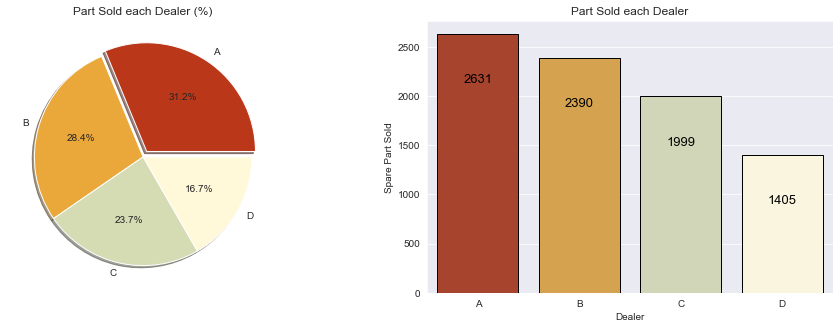

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].pie(dealer_count['Spare Part Sold'], labels=dealer_count['Dealer'], explode=[0.06, 0, 0, 0], colors=[
    '#BB371A', '#EBA83A', '#D5DBB3', '#FFF8D9'], autopct='%1.1f%%', shadow=True, startangle=0)
ax[0].set_title("Part Sold each Dealer (%)")
ax[0].set_ylabel('')

sns.barplot(data= dealer_count,x='Dealer', y= 'Spare Part Sold', palette= [
    '#BB371A', '#EBA83A', '#D5DBB3', '#FFF8D9'], edgecolor='black', ax=ax[1])
for k,v in dealer_count["Spare Part Sold"].items(): #To show the exact revenue generated on the figure
        plt.text(k,v-500, str(v), fontsize=13,color='k', horizontalalignment='center');
ax[1].set_title("Part Sold each Dealer")
plt.show()

*Insight*:
- Dari ke- 4 dealer, Penjualan Spare Part paling banyak terjadi di **Dealer A**
- Sebaliknya **Dealer D** menjadi penjualan paling sedikit selama 4 tahun terakhir

### Which product Mostly needed  in 4 years?

In [16]:
product_count = data_viz.groupby('Product Name')[['Product Name']].count().rename(columns={
    'Product Name': 'Spare Part Sold'}).reset_index()
product_count

,Product Name,Spare Part Sold
0,Fender,950
1,Filter,437
2,Fog Lamp,744
3,Front Bumper,1442
4,Grille,1004
5,Headlight,1292
6,Indicator Lamp,873
7,Rear Bumper,334
8,Side Mirror,800
9,Tail Lamp,549


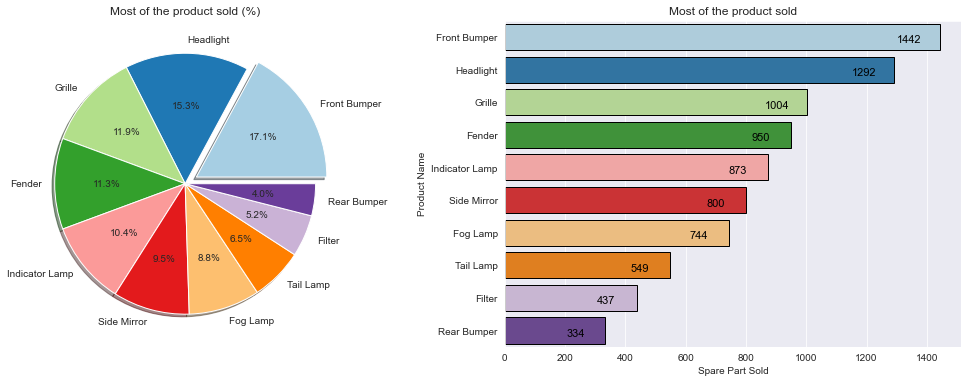

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].pie(data =product_count.sort_values(by='Spare Part Sold', ascending=False), 
          x='Spare Part Sold', 
          labels='Product Name', 
          explode=[0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
          autopct='%1.1f%%', shadow=True, startangle=0)
ax[0].set_title("Most of the product sold (%)")
ax[0].set_ylabel('')


# sns.color_palette("Paired", 10)
sns.barplot(data= product_count.sort_values(by= 'Spare Part Sold', ascending=False),x='Spare Part Sold', 
            y= 'Product Name', edgecolor='black')
for k, v in enumerate(product_count["Spare Part Sold"].sort_values(ascending=False)):
        plt.text(v-100, k+.18, str(v), fontsize=11,color='k', horizontalalignment='center');

ax[1].set_title("Most of the product sold")
plt.show()

*Insight*:
- **Front Bumper** menjadi Part yang paling dibutuhkan oleh *customer* dibandingkan **Rear Bumper**
- Dapat dilihat bahwa spare part yang paling dicari *customer* adalah spare part bagian depan kendaraan

### How is the sales everyday

In [18]:
product_daily = data_viz.groupby([pd.Grouper(key= 'Order Date', freq='M'), 
                                  'Product Name'])[['Product Name']].count().rename(columns={'Product Name': 'Part Sold'}).reset_index()
product_daily.sort_values(by='Part Sold', ascending=False)

,Order Date,Product Name,Part Sold
445,2018-09-30,Headlight,61
463,2018-11-30,Front Bumper,55
443,2018-09-30,Front Bumper,52
473,2018-12-31,Front Bumper,51
203,2016-09-30,Front Bumper,48
...,...,...,...
19,2015-02-28,Tail Lamp,1
67,2015-07-31,Rear Bumper,1
47,2015-05-31,Rear Bumper,1
77,2015-08-31,Rear Bumper,1


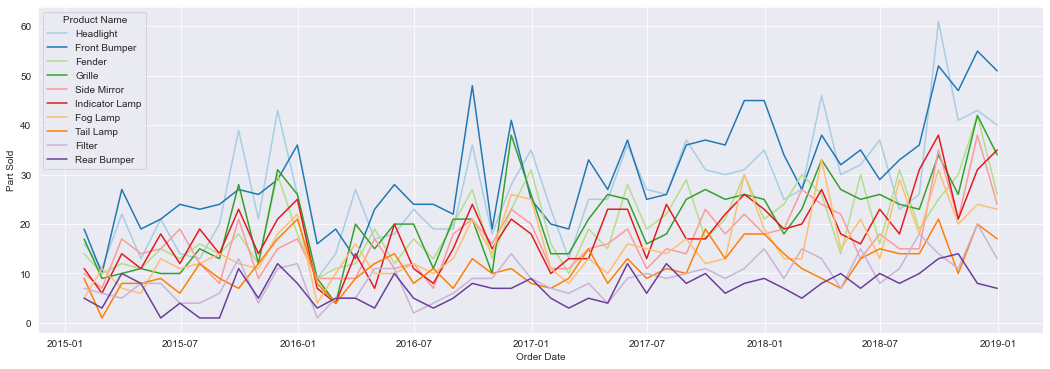

In [19]:
plt.figure(figsize=(18, 6))
sns.lineplot(data= product_daily.sort_values(by='Part Sold', ascending=False), 
             x= 'Order Date', y= 'Part Sold', hue= 'Product Name')
plt.show()

*Insight*:
- Jika dilihat dari penjualan, dalam satu minggu pada **30 September 2018** terjadi pembelian **Headlight** sebanyak **61 unit**
- Dan untuk Unit **Tail Lamp, Filter** dan **Rear Bumper** merupakan unit yang dalam 1 minggu penjualan yang hanya terjual **1 unit**

### How is the trend of sales over 4 years

In [20]:
trend_sales = data_viz.copy()
trend_sales = trend_sales.set_index('Order Date')
trend_sales = pd.DataFrame(trend_sales.resample('W')['Product Name'].count())
trend_sales = trend_sales.rename(columns={'Product Name' : 'Product Sold'}).reset_index()
trend_sales.head(10)

,Order Date,Product Sold
0,2015-01-04,14
1,2015-01-11,41
2,2015-01-18,28
3,2015-01-25,17
4,2015-02-01,13
5,2015-02-08,21
6,2015-02-15,39
7,2015-02-22,10
8,2015-03-01,5
9,2015-03-08,18


In [21]:
trend_sales['EMA'] = trend_sales['Product Sold'].ewm(alpha=0.2, adjust=False).mean()
trend_sales.head(10)

,Order Date,Product Sold,EMA
0,2015-01-04,14,14.000000
1,2015-01-11,41,19.400000
2,2015-01-18,28,21.120000
3,2015-01-25,17,20.296000
4,2015-02-01,13,18.836800
5,2015-02-08,21,19.269440
6,2015-02-15,39,23.215552
7,2015-02-22,10,20.572442
8,2015-03-01,5,17.457953
9,2015-03-08,18,17.566363


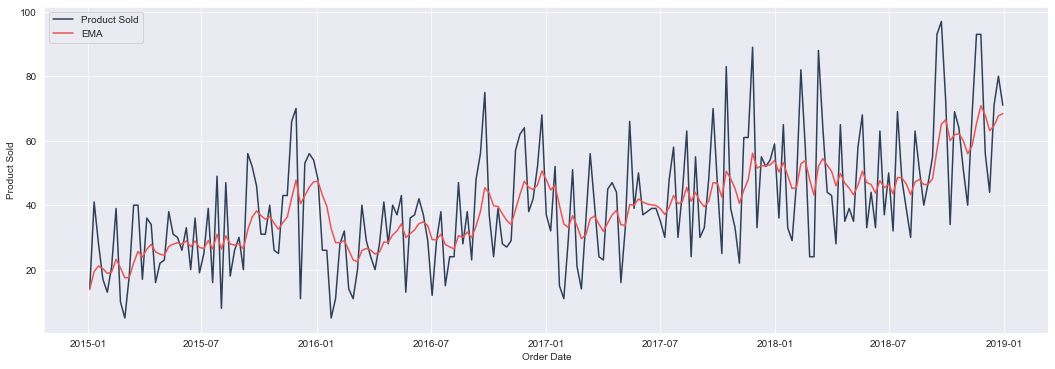

In [47]:
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(ax= ax, data = trend_sales, x='Order Date', y='Product Sold', label='Product Sold', color='#2D4059')
sns.lineplot(ax= ax, data = trend_sales, x='Order Date', y='EMA',  label= 'EMA', color='#EA5455')
ax.legend()
plt.show()

*Insight*:
- Menggunakan **Exponential Moving Average** untuk melihat trend, 
- Terdapat pola dari penjualan spare part selama 4 tahun yaitu Penjualan **cenderung meningkat** seiring berjalannya waktu menuju akhir tahun, namun setiap awal tahun akan terjadi **penurunan** penjualan
- Dari grafik ini juga bisa disimpulkan bahwa penjualan mengalami **Uptrend** yang artinya selama 4 tahun, penjualan cenderung naik

# 3. Machine Learning Model

## 3.1 Initiate Model  

In [22]:
from fbprophet import Prophet
model = Prophet()
model

In [23]:
forecast.reset_index()

,Order Date,Quantity
0,2015-01-02,1
1,2015-01-03,9
2,2015-01-04,4
3,2015-01-05,0
4,2015-01-06,10
...,...,...
1454,2018-12-26,4
1455,2018-12-27,2
1456,2018-12-28,17
1457,2018-12-29,10


## 3.2 Training Model

In [24]:
forecast = forecast.reset_index()
forecast.columns = ['ds', 'y']
forecast

,ds,y
0,2015-01-02,1
1,2015-01-03,9
2,2015-01-04,4
3,2015-01-05,0
4,2015-01-06,10
...,...,...
1454,2018-12-26,4
1455,2018-12-27,2
1456,2018-12-28,17
1457,2018-12-29,10


In [25]:
model.fit(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
model.component_modes

{'additive': ['yearly',
  'weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [27]:
future_data = model.make_future_dataframe(periods=181, freq='D')
future_data

,ds
0,2015-01-02
1,2015-01-03
2,2015-01-04
3,2015-01-05
4,2015-01-06
...,...
1635,2019-06-25
1636,2019-06-26
1637,2019-06-27
1638,2019-06-28


In [28]:
predict = model.predict(future_data)
predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,3.981944,-1.549010,10.987688,3.981944,3.981944,0.915571,0.915571,0.915571,-1.104245,-1.104245,-1.104245,2.019816,2.019816,2.019816,0.0,0.0,0.0,4.897515
1,2015-01-03,3.983984,0.261457,12.773864,3.983984,3.983984,2.459887,2.459887,2.459887,0.696632,0.696632,0.696632,1.763254,1.763254,1.763254,0.0,0.0,0.0,6.443870
2,2015-01-04,3.986024,-0.298121,12.015968,3.986024,3.986024,2.057622,2.057622,2.057622,0.584035,0.584035,0.584035,1.473587,1.473587,1.473587,0.0,0.0,0.0,6.043646
3,2015-01-05,3.988063,-0.435639,12.078769,3.988063,3.988063,1.781753,1.781753,1.781753,0.625582,0.625582,0.625582,1.156171,1.156171,1.156171,0.0,0.0,0.0,5.769817
4,2015-01-06,3.990103,0.326851,12.462391,3.990103,3.990103,2.347844,2.347844,2.347844,1.530788,1.530788,1.530788,0.817055,0.817055,0.817055,0.0,0.0,0.0,6.337947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,2019-06-25,8.767920,3.573514,15.970607,8.750215,8.786011,0.985436,0.985436,0.985436,1.530788,1.530788,1.530788,-0.545353,-0.545353,-0.545353,0.0,0.0,0.0,9.753355
1636,2019-06-26,8.771536,1.886980,14.634866,8.753696,8.789873,-0.726436,-0.726436,-0.726436,-0.270491,-0.270491,-0.270491,-0.455945,-0.455945,-0.455945,0.0,0.0,0.0,8.045100
1637,2019-06-27,8.775152,0.730033,12.555272,8.757167,8.793574,-2.438008,-2.438008,-2.438008,-2.062302,-2.062302,-2.062302,-0.375706,-0.375706,-0.375706,0.0,0.0,0.0,6.337144
1638,2019-06-28,8.778769,1.019876,13.610079,8.760630,8.797291,-1.411435,-1.411435,-1.411435,-1.104245,-1.104245,-1.104245,-0.307190,-0.307190,-0.307190,0.0,0.0,0.0,7.367334


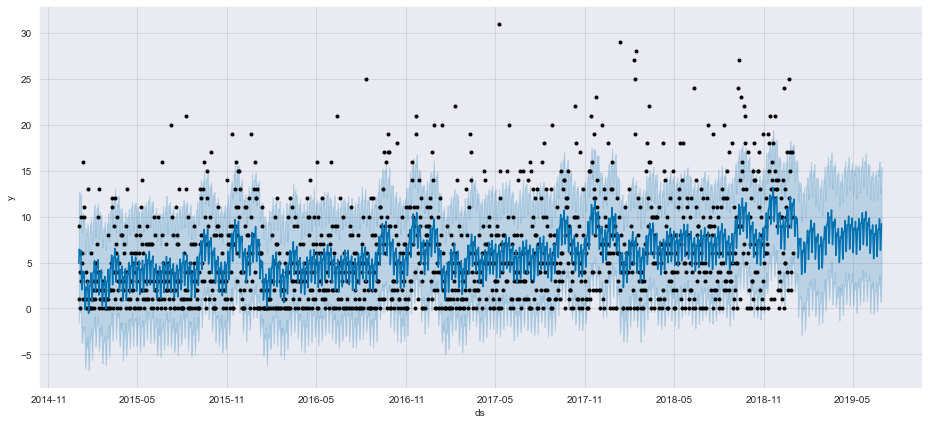

In [29]:
model.plot(predict, figsize=(13, 6));

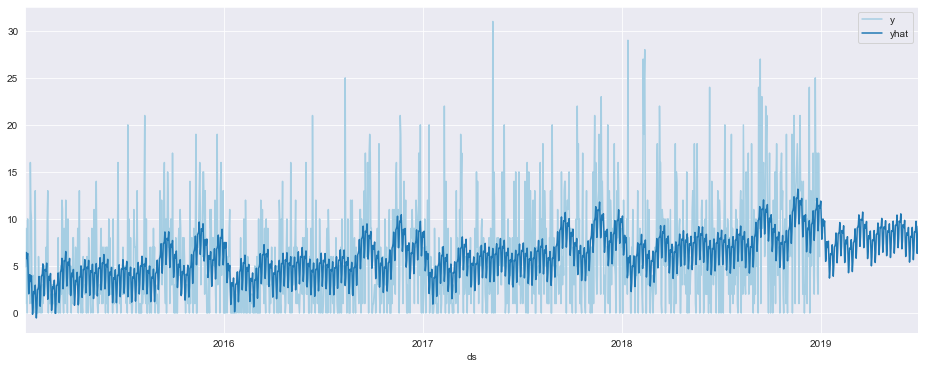

In [30]:
result = pd.concat([forecast.set_index('ds')['y'], predict.set_index('ds')['yhat']], axis=1)
result.plot(figsize= (16, 6))
plt.show()

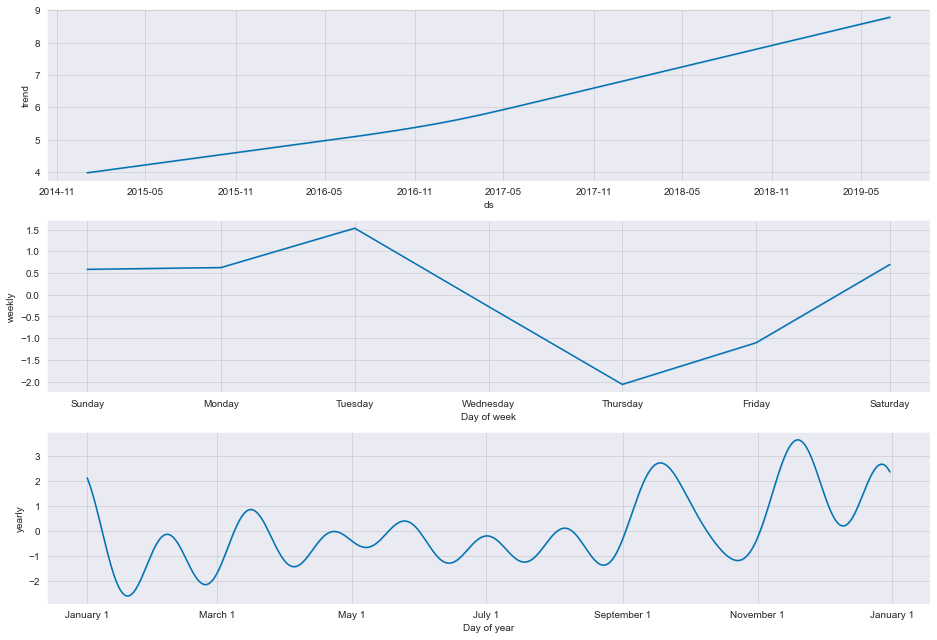

In [31]:
model.plot_components(predict, figsize=(13, 9));

## 3.3 Model Evaluation

In [32]:
from fbprophet.diagnostics import cross_validation, performance_metrics
cv_result = cross_validation(model, initial='730 days', period='180 days', horizon= '365 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-01-04 00:00:00 and 2017-12-30 00:00:00


In [33]:
cv_result

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-05,5.209372,0.086558,9.993253,4,2017-01-04
1,2017-01-06,2.599990,-2.723151,7.804706,0,2017-01-04
2,2017-01-07,6.030789,0.684803,11.129043,7,2017-01-04
3,2017-01-08,5.683955,0.478726,10.816535,4,2017-01-04
4,2017-01-09,4.634149,0.065480,9.731881,12,2017-01-04
...,...,...,...,...,...,...
1090,2018-12-26,10.066816,4.675358,15.574092,4,2017-12-30
1091,2018-12-27,8.396294,2.760037,14.463836,2,2017-12-30
1092,2018-12-28,7.798215,2.176553,13.294204,17,2017-12-30
1093,2018-12-29,10.222546,4.813427,16.226908,10,2017-12-30


In [34]:
performance = performance_metrics(cv_result)
performance

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,37 days,31.007362,5.568425,3.793129,0.568657,0.788991
1,38 days,31.161843,5.582279,3.821990,0.554079,0.788991
2,39 days,31.501126,5.612586,3.875350,0.568657,0.785933
3,40 days,30.616182,5.533189,3.837100,0.568657,0.792049
4,41 days,34.596018,5.881838,3.921794,0.554079,0.801223
...,...,...,...,...,...,...
324,361 days,29.839847,5.462586,4.366839,0.438983,0.685015
325,362 days,30.038381,5.480728,4.394529,0.446157,0.678899
326,363 days,30.961390,5.564296,4.476471,0.450171,0.666667
327,364 days,31.313949,5.595887,4.505141,0.466724,0.657492


## Root Mean Square Error (Forecast 1 year)

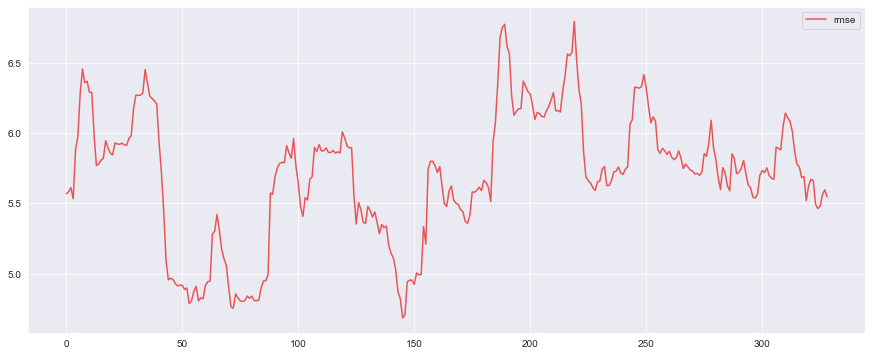

In [35]:
evaluation = performance.set_index('horizon')
performance[['rmse']].plot(figsize=(15,6), color='#EA5455')
plt.show()

# Objective:

### Top 5 SKU parts mana yang dalam waktu 6 bulan kedepan di butuhkan region / wilayah se nasional

In [36]:
df.head()

,Order Date,State,Dealer,Product Name,Quantity,SKU
0,2015-01-02,Wisconsin,C,Fog Lamp,1,SV-20365
1,2015-01-03,Illinois,C,Headlight,1,MA-17560
2,2015-01-03,Illinois,C,Tail Lamp,1,EP-13915
3,2015-01-03,New York,B,Fender,1,JL-15835
4,2015-01-03,Texas,C,Fender,1,JL-15835


In [37]:
def time_features(data):
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    data['Week'] = data.index.week
    return data

In [38]:
obj_1 = df.copy()
obj_1['Order Date'] = pd.to_datetime(obj_1['Order Date'])
obj_1 = obj_1.set_index('Order Date')
obj_1['Month'] = obj_1.index.month
obj_1

,State,Dealer,Product Name,Quantity,SKU,Month
Order Date,,,,,,
2015-01-02,Wisconsin,C,Fog Lamp,1,SV-20365,1
2015-01-03,Illinois,C,Headlight,1,MA-17560,1
2015-01-03,Illinois,C,Tail Lamp,1,EP-13915,1
2015-01-03,New York,B,Fender,1,JL-15835,1
2015-01-03,Texas,C,Fender,1,JL-15835,1
...,...,...,...,...,...,...
2018-12-30,Colorado,A,Fender,1,JL-15835,12
2018-12-30,Indiana,C,Filter,1,AP-10915,12
2018-12-30,New York,B,Fender,1,JL-15835,12


In [39]:
obj_1 = obj_1.loc[obj_1.index.month < 7].reset_index()
obj_1

,Order Date,State,Dealer,Product Name,Quantity,SKU,Month
0,2015-01-02,Wisconsin,C,Fog Lamp,1,SV-20365,1
1,2015-01-03,Illinois,C,Headlight,1,MA-17560,1
2,2015-01-03,Illinois,C,Tail Lamp,1,EP-13915,1
3,2015-01-03,New York,B,Fender,1,JL-15835,1
4,2015-01-03,Texas,C,Fender,1,JL-15835,1
...,...,...,...,...,...,...,...
3528,2018-06-30,New York,B,Front Bumper,1,WB-21850,6
3529,2018-06-30,New York,B,Grille,1,PP-18955,6
3530,2018-06-30,New York,B,Indicator Lamp,2,JD-15895,6
3531,2018-06-30,North Carolina,A,Front Bumper,1,WB-21850,6


In [40]:
grouped = obj_1.groupby('Product Name')[['Product Name']].count().rename(columns={
    'Product Name': 'Part Sold'}).reset_index()
grouped

,Product Name,Part Sold
0,Fender,402
1,Filter,184
2,Fog Lamp,296
3,Front Bumper,599
4,Grille,423
5,Headlight,551
6,Indicator Lamp,353
7,Rear Bumper,144
8,Side Mirror,355
9,Tail Lamp,226


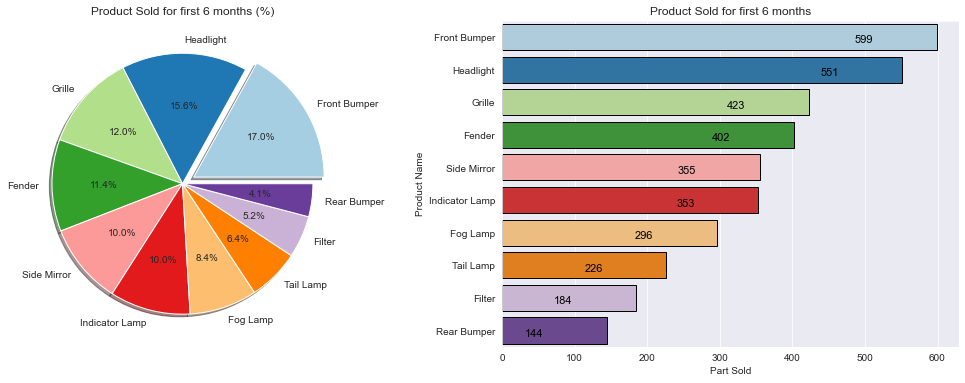

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].pie(data =grouped.sort_values(by='Part Sold', ascending=False), 
          x='Part Sold', 
          labels='Product Name', 
          explode=[0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  
          autopct='%1.1f%%', shadow=True, startangle=0)
ax[0].set_title("Product Sold for first 6 months (%)")
ax[0].set_ylabel('')


# sns.color_palette("Paired", 10)
sns.barplot(data= grouped.sort_values(by= 'Part Sold', ascending=False),x='Part Sold', 
            y= 'Product Name', edgecolor='black')
for k, v in enumerate(grouped["Part Sold"].sort_values(ascending=False)):
        plt.text(v-100, k+.18, str(v), fontsize=11,color='k', horizontalalignment='center');

ax[1].set_title("Product Sold for first 6 months")
plt.show()

**Insight**:
- Grafik di atas merupakan akumulasi barang yang terjual selama 4 tahun dalam waktu 6 bulan pertama
- Artinya, top 5 produk yang akan terjual dalam 6 bulan kedepan kemungkinan ialah **Front Bumper,  Headlight, Grille, Fender, dan Side Mirror**


In [42]:
grouped['SKU'] = grouped['Product Name']
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Front Bumper', 'WB-21850')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Headlight', 'MA-17560')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Grille', 'PP-18955')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Fender', 'JL-15835')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Indicator Lamp', 'JD-15895')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Side Mirror', 'CK-12205')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Fog Lamp', 'SV-20365')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Tail Lamp', 'EP-13915')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Filter', 'AP-10915')
grouped['SKU'] = grouped['SKU'].where(grouped['Product Name'] != 'Rear Bumper', 'ZC-21910')
grouped

,Product Name,Part Sold,SKU
0,Fender,402,JL-15835
1,Filter,184,AP-10915
2,Fog Lamp,296,SV-20365
3,Front Bumper,599,WB-21850
4,Grille,423,PP-18955
5,Headlight,551,MA-17560
6,Indicator Lamp,353,JD-15895
7,Rear Bumper,144,ZC-21910
8,Side Mirror,355,CK-12205
9,Tail Lamp,226,EP-13915


In [43]:
prediction = predict.set_index('ds')
prediction = prediction.loc[prediction.index.year >= 2019]
prediction

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2019-01-01,8.135052,5.816558,17.992210,8.135052,8.135052,3.769532,3.769532,3.769532,1.530788,1.530788,1.530788,2.238743,2.238743,2.238743,0.0,0.0,0.0,11.904584
2019-01-02,8.138668,3.716600,16.194318,8.138668,8.138668,1.749325,1.749325,1.749325,-0.270491,-0.270491,-0.270491,2.019816,2.019816,2.019816,0.0,0.0,0.0,9.887994
2019-01-03,8.142285,1.849720,13.864890,8.142285,8.142285,-0.299048,-0.299048,-0.299048,-2.062302,-2.062302,-2.062302,1.763254,1.763254,1.763254,0.0,0.0,0.0,7.843237
2019-01-04,8.145901,2.311169,14.650613,8.145901,8.145901,0.369342,0.369342,0.369342,-1.104245,-1.104245,-1.104245,1.473587,1.473587,1.473587,0.0,0.0,0.0,8.515243
2019-01-05,8.149518,3.758772,16.110782,8.149518,8.149518,1.852803,1.852803,1.852803,0.696632,0.696632,0.696632,1.156171,1.156171,1.156171,0.0,0.0,0.0,10.002321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-25,8.767920,3.573514,15.970607,8.750215,8.786011,0.985436,0.985436,0.985436,1.530788,1.530788,1.530788,-0.545353,-0.545353,-0.545353,0.0,0.0,0.0,9.753355
2019-06-26,8.771536,1.886980,14.634866,8.753696,8.789873,-0.726436,-0.726436,-0.726436,-0.270491,-0.270491,-0.270491,-0.455945,-0.455945,-0.455945,0.0,0.0,0.0,8.045100
2019-06-27,8.775152,0.730033,12.555272,8.757167,8.793574,-2.438008,-2.438008,-2.438008,-2.062302,-2.062302,-2.062302,-0.375706,-0.375706,-0.375706,0.0,0.0,0.0,6.337144


In [44]:
qty_prediction = prediction['yhat'].sum().round(0).astype(int)
qty_prediction

1409

### Berikut adalah Prediksi top 5 SKU PART yang akan dibutuhkan untuk setiap wilayah beserta jumlahnya

In [45]:
final = grouped.sort_values(by='Part Sold', ascending=False)
final.columns = ['Product Name','Quantity', 'SKU']
final['Quantity Need'] = final['Quantity']
final['Quantity Need'] = final['Quantity Need'].where(final['Product Name'] != 'Front Bumper', (qty_prediction*17)/100)
final['Quantity Need'] = final['Quantity Need'].where(final['Product Name'] != 'Headlight', (qty_prediction*15.6)/100)
final['Quantity Need'] = final['Quantity Need'].where(final['Product Name'] != 'Grille', (qty_prediction*12)/100)
final['Quantity Need'] = final['Quantity Need'].where(final['Product Name'] != 'Fender', (qty_prediction*11.4)/100)
final['Quantity Need'] = final['Quantity Need'].where(final['Product Name'] != 'Side Mirror', (qty_prediction*10)/100)
final['Quantity Need'] = final['Quantity Need'].round(0).astype(int)

In [46]:
final = final[['Product Name', 'SKU', 'Quantity Need']]
final.reset_index(drop=True).head()

,Product Name,SKU,Quantity Need
0,Front Bumper,WB-21850,240
1,Headlight,MA-17560,220
2,Grille,PP-18955,169
3,Fender,JL-15835,161
4,Side Mirror,CK-12205,141
